In [1]:
%matplotlib notebook

In [2]:
from meshmaker import vec3, quat, planargraph, show, Base, Mesh
from meshmaker.geometry import slide
from meshmaker.plt import *
from collections import defaultdict
import numpy as np

In [3]:
class Seam(Base):
    
    """need a parameterization of a loop for windows"""
    
    @classmethod
    def l2s(cls, loop, m=0):
        s = [cls(u, v) for u, v in slide(loop, 2, m)]
        for i in range(1, len(s)):
            s[i - 1].next = s[i]
        return s[0]
        
    def slide(self, n=2, m=1):
        # this doesnt work because __iter__ cant receive n
        yield from slide(list(self), n=n, m=m)
        
    def __init__(self, u, v, n=0, du=None, dv=None, **kws):
        du = (v - u).nrm() if du is None else du
        dv = (u - v).nrm() if dv is None else dv
        super().__init__(u=u, v=v, n=n, du=du, dv=dv, **kws)

    def __iter__(self):
        yield from self._iter()
        
    def _iter(self, n=None):
        m = self.n if n is None else n
        if m == 0:
            yield self.u
            #yield self.v
        else:
            yield self.u
            yield from self.u.spline(self.v, self.du, self.dv, m, alpha=1)
        if not (hasattr(self, 'next') and self.next.u.isnear(self.v)):
            yield self.v
        if hasattr(self, 'next'):
            yield from self.next._iter(n=n)

    def _control(self):
        unique = []
        for p in self._iter(n=0):
            if not p in unique:
                unique.append(p)
        return unique

    def trn(self, t):
        t.trnps(self._control())
        return self

    def scl(self, s):
        s.sclps(self._control())
        return self
            
    def rot(self, q):
        q.rot(self._control())
        return self

    def cp(self, root=True):
        cp = Seam(self.u.cp(), self.v.cp(), self.n,
                  self.du.cp(), self.dv.cp())
        if hasattr(self, 'next'):
            cp.next = self.next.cp(False)
            cp.next.u = cp.v
        if root and self._closed():
            cp._last().v = cp.u
        return cp
            
    def _last(self):
        return self.next._last() if hasattr(self, 'next') else self
        
    def _closed(self):
        return self._last().v.isnear(self.u)
        
    def loop(self, n=None):
        points = list(self._iter(n=n))
        if self._closed():
            points.pop(-1)
        return points

In [4]:
ring = vec3.O().ring(2, 4, True)

a, b, c, d = ring
a, b, c, d = a.lerp(b, 0.5), b.lerp(c, 0.5), c.lerp(d, 0.5), d.lerp(a, 0.5)

x, y = Seam(a, c), Seam(b, d)
x.du.rot(quat.rotz(-np.pi / 6))
x.dv.rot(quat.rotz(np.pi / 8))
y.du.rot(quat.rotz(np.pi / 6))
y.dv.rot(quat.rotz(np.pi / 6))
x.n = y.n = 10
x, y = list(x), list(y)

pg = planargraph()
for l, m in ((ring, 0), (x, 1), (y, 1)):
    for u, v in slide(l, 2, m):
        seam = Seam(u, v, n=int(u.d(v) / 0.2))
        pg.ae(u, v, seam=seam)
pg.dissolve(0.1)

<IPython.core.display.Javascript object>


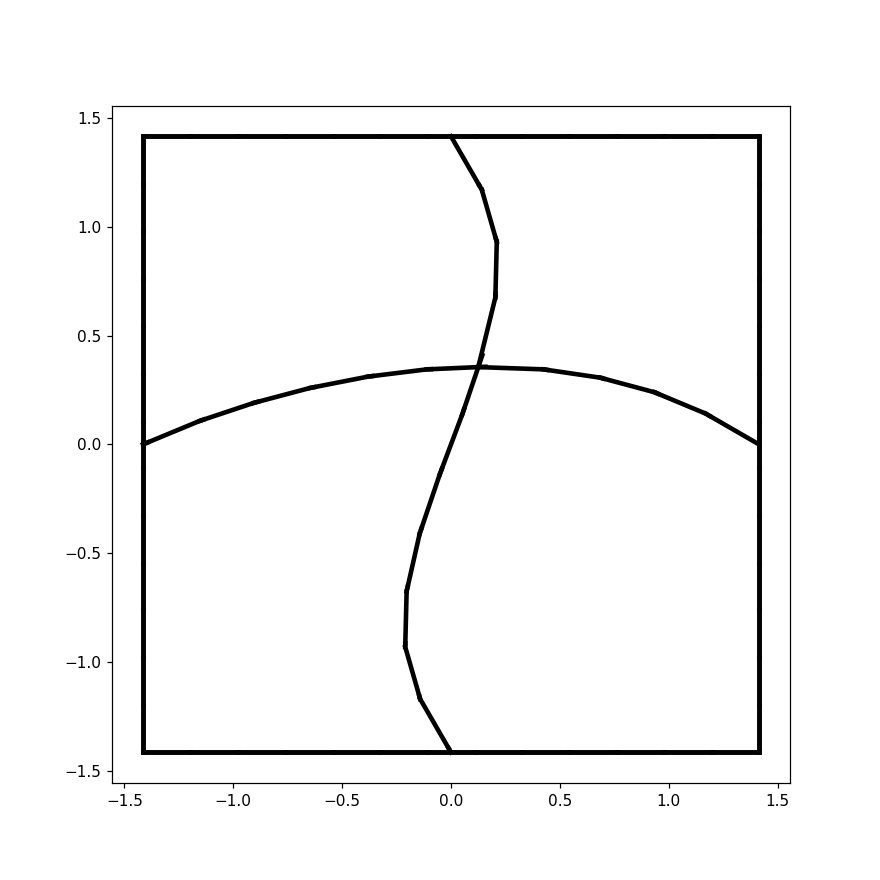

In [8]:
f, ax = plot()
ax.set_aspect(1)

rg = planargraph()
for e in pg.edges:
    if e is not None:
        i, j, e = e
        
        seam = e.get('seam', None)
        if seam is None:
            seam = [pg.vertices[i].cp(), pg.vertices[j].cp()]
        else:
            seam = list(seam)

        #plot_edges(ax, seam, mk='s')
        
        for u, v in slide(seam, 2, 1):
            if not u.isnear(v):
                rg.ae(u, v)

                plot_edge(ax, u, v)

In [10]:
def socket_pair(pg, i, j):
    Z = vec3.Z()
    rw = 0.1
    
    p, q = pg.vertices[i], pg.vertices[j]
    ring = tuple(pg.rings[i])
    
    o = 0
    t = (q - p).nrm()
    n = Z.crs(t).nrm()
    
    # offset o from q by the exact right amount
    if len(ring) == 1:
        pass
    elif len(ring) >= 2:
        k = tuple(filter(lambda l: l != j, ring))
        k = min(k, key=lambda l: t.axy(pg.vertices[l] - p))
        a = t.axy(pg.vertices[k] - p)
        o += rw / np.tan(a / 2)
        
    o /= np.cos(t.ang(t.xy()))
    u = p + (t * o) - (n * rw)
    v = p + (t * o) + (n * rw)
    return u, v


def road_mesh(rg):
    mesh = Mesh()

    pairs = {}
    for i, j, e in filter(None, rg.edges):
        pairs[(i, j)] = socket_pair(rg, i, j)
        pairs[(j, i)] = socket_pair(rg, j, i)

    X = vec3.X()
    for i, p in enumerate(rg.vertices):
        if p is not None:
            points = [((rg.vertices[j] - p).nrm(), pairs[(i, j)]) for j in rg.rings[i]]
            points.sort(key=lambda p: X.saxy(p[0]))
            if len(points) > 1:
                points = [x for y in points for x in y[1]]
                for x, y in slide(points, 2):                    
                    mesh.af((p, x, y))

    for i, j in pairs:
        if i < j:
            x, y = pairs[(i, j)]
            w, z = pairs[(j, i)]
            mesh.af((y, x, z, w))

    mesh.uvs = mesh.project_uvs_xy(4.0)
            
    return mesh

In [11]:
show(road_mesh(rg))

/home/cogle/dev/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/cogle/dev/mine/meshmaker/meshmaker/vec3.py:92: RuntimeWarning: invalid value encountered in double_scalars
  return vec3(self.x * o, self.y * o, self.z * o)
/home/cogle/dev/mine/meshmaker/meshmaker/vec3.py:141: RuntimeWarning: invalid value encountered in double_scalars
  cosa = (self.dot(o) / (self.mag() * o.mag()))
/home/cogle/dev/mine/meshmaker/meshmaker/geometry.py:10: RuntimeWarning: invalid value encountered in double_scalars
  d = a - b
/home/cogle/dev/mine/meshmaker/meshmaker/vec3.py:210: RuntimeWarning: invalid value encountered in double_scalars
  return vec3(self.y * o.z - self.z * o.y,
/home/cogle/dev/mine/meshmaker/meshmaker/vec3.py:211: RuntimeWarning: invalid value encountered in double_scalars
  self.z * o.x - self.x * o.z,
/home/cogle/dev/mine/meshmaker/meshmaker/vec3.py:212: RuntimeWarning: invalid value encountered in doub

Loaded texture: generic_0 (../resources/textures/generics/generic_0.png)


<IPython.core.display.Javascript object>


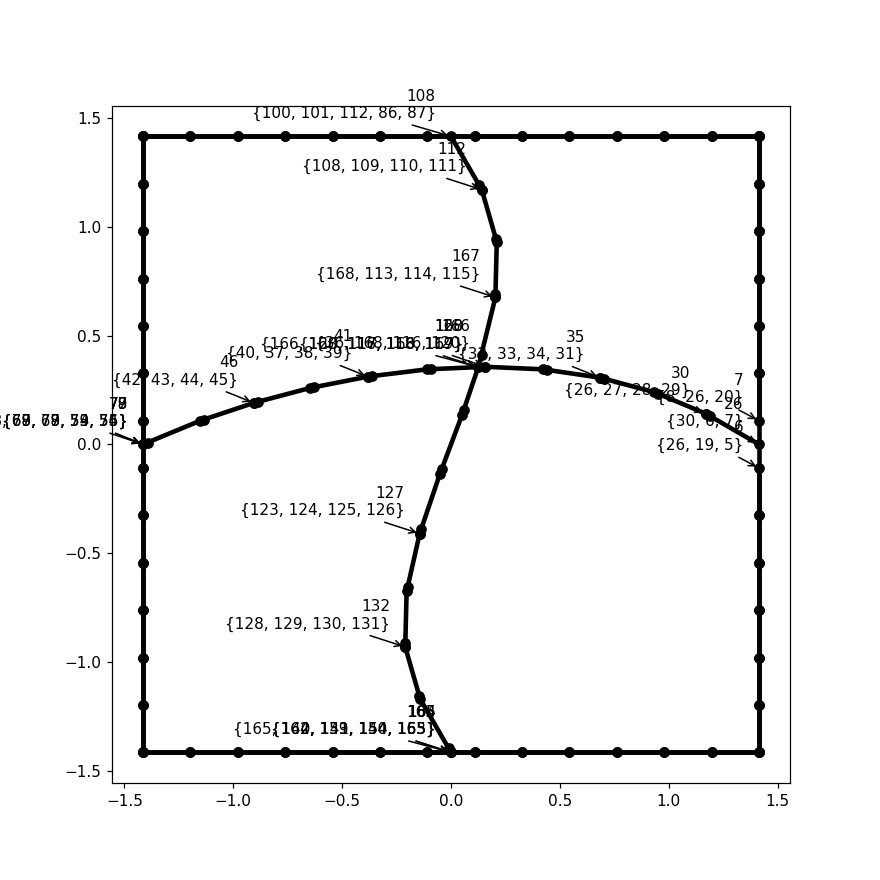

In [12]:
f, ax = plot()
ax.set_aspect(1)
#plot_edges(ax, x, mk='*')
#plot_edges(ax, y, mk='*')
plot_pg(ax, rg)